<a href="https://colab.research.google.com/github/Tyred/TimeSeries_OCC-PUL/blob/main/MLP_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> One-Class Classification Using MLP Autoencoder </h1>

The main idea is to train a MLP Autoencoder with data from the positive class only and calculate a reconstruction error threshold T based on the reconstruction errors obtained during the training. <br/>
Then we perform the One-Class Classification (OCC) as follows:

- For each data sample in the test dataset, do:
    - Reconstruct the data with the MLP and calculate its reconstruction error E.
    - if E <= T the sample is classified as a member of the positive class.
    - else (if E > T) the sample is classified as not a member of the positive class.  

- Evaluate the Model's Accuracy, Precision and Recall.

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

# Reading Dataset from Google Drive

In [211]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')
tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", 
                        delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", 
                        delimiter="\t",)

labels = te_data[:, 0]
print("Labels:", np.unique(labels))

Dataset: StarLightCurves
Labels: [1. 2. 3.]


# Splitting in Train-Test data

In [212]:
class_label = int(input('Positive class label: '))

train_data  = tr_data[tr_data[:, 0] == class_label, 1:] # train
test_data   = te_data[:, 1:]                            # test
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_data = tf.cast(train_data, tf.float32)
test_data  = tf.cast(test_data , tf.float32)

serie_length = train_data.shape[1]

Positive class label: 3
Train data shape: (573, 1024)
Test data shape: (8236, 1024)


# Labeling for OCC Task

In [213]:
occ_labels = [1 if x == class_label else 0 for x in labels]
print("Positive samples:", occ_labels.count(1))
print("Negative samples:", occ_labels.count(0))

positive_test_data = test_data[np.array(occ_labels).astype(bool)]
negative_test_data = test_data[~np.array(occ_labels).astype(bool)]

Positive samples: 4754
Negative samples: 3482


## MLP Autoencoder

In [214]:
class AnomalyDetector(tf.keras.Model):
  def __init__(self, serie_length):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation="swish"),
      tf.keras.layers.Dense(64, activation="swish"),
      tf.keras.layers.Dense(16, activation="swish")])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation="swish"),
      tf.keras.layers.Dense(128, activation="swish"),
      tf.keras.layers.Dense(serie_length, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
  def model(self):
    x = keras.layers.Input(shape=(serie_length))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

autoencoder = AnomalyDetector(serie_length)

In [215]:
autoencoder.compile(optimizer='adam', loss='mse')

In [216]:
# Train
batch_size = 32
epochs = 50

history = autoencoder.fit(train_data, train_data, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_data=(test_data, test_data))

Epoch 1/50
18/18 [==============================] - 1s 38ms/step - loss: 0.5489 - val_loss: 0.3794
Epoch 2/50
18/18 [==============================] - 1s 43ms/step - loss: 0.1020 - val_loss: 0.2813
Epoch 3/50
18/18 [==============================] - 1s 42ms/step - loss: 0.0526 - val_loss: 0.2680
Epoch 4/50
18/18 [==============================] - 1s 30ms/step - loss: 0.0446 - val_loss: 0.2649
Epoch 5/50
18/18 [==============================] - 1s 31ms/step - loss: 0.0403 - val_loss: 0.2603
Epoch 6/50
18/18 [==============================] - 0s 29ms/step - loss: 0.0370 - val_loss: 0.2560
Epoch 7/50
18/18 [==============================] - 1s 44ms/step - loss: 0.0331 - val_loss: 0.2527
Epoch 8/50
18/18 [==============================] - 1s 31ms/step - loss: 0.0296 - val_loss: 0.2463
Epoch 9/50
18/18 [==============================] - 1s 42ms/step - loss: 0.0268 - val_loss: 0.2440
Epoch 10/50
18/18 [==============================] - 1s 43ms/step - loss: 0.0259 - val_loss: 0.2375
Epoch 11/

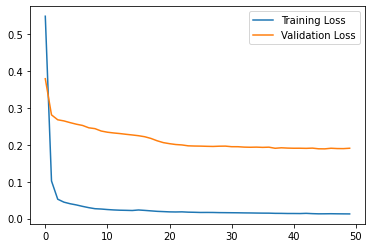

In [217]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [218]:
autoencoder.model().summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
sequential_22 (Sequential)   (None, 16)                140496    
_________________________________________________________________
sequential_23 (Sequential)   (None, 1024)              141504    
Total params: 282,000
Trainable params: 282,000
Non-trainable params: 0
_________________________________________________________________


# Reconstruction examples

## Positive Class

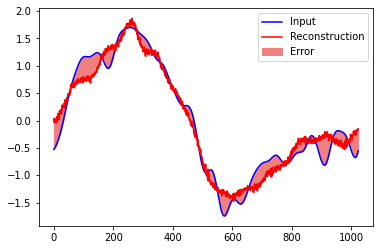

In [219]:
encoded_data = autoencoder.encoder(positive_test_data)
decoded_data = autoencoder.decoder(encoded_data)

plt.plot(positive_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(serie_length), decoded_data[0], 
                 positive_test_data[0], color='lightcoral')

plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Negative Class

(3482, 1024)


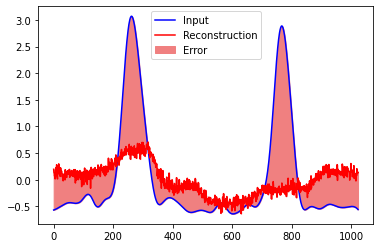

In [220]:
print(negative_test_data.shape)
encoded_data = autoencoder.encoder(negative_test_data)
decoded_data = autoencoder.decoder(encoded_data)

plt.plot(negative_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(serie_length), decoded_data[0], 
                 negative_test_data[0], color='lightcoral')

plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# Reconstruction Error Histogram

## Train 

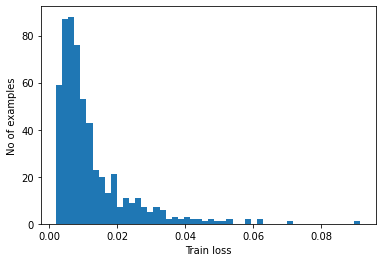

In [221]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## Test - Negative Class

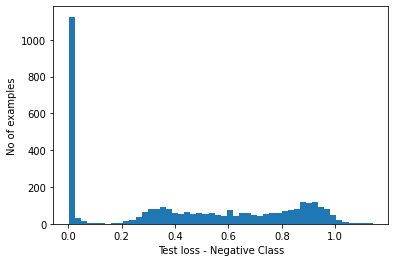

In [222]:
reconstructions = autoencoder.predict(negative_test_data)
negative_test_loss = tf.keras.losses.mse(reconstructions, negative_test_data)

plt.hist(negative_test_loss[None,:], bins=50)
plt.xlabel("Test loss - Negative Class")
plt.ylabel("No of examples")
plt.show()

## Test - Positive Class

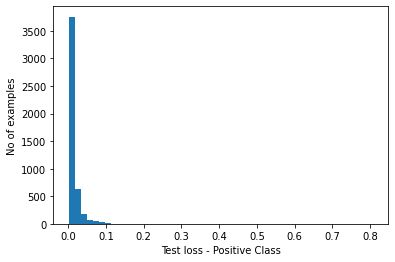

In [223]:
reconstructions = autoencoder.predict(positive_test_data)
positive_test_loss = tf.keras.losses.mse(reconstructions, positive_test_data)

plt.hist(positive_test_loss[None,:], bins=50)
plt.xlabel("Test loss - Positive Class")
plt.ylabel("No of examples")
plt.show()

# Threshold Definition and OCC Task








In [224]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less_equal(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = %.2f"  % (accuracy_score(labels, predictions)  *100) + "%")
  print("Precision = %.2f" % (precision_score(labels, predictions) *100) + "%")
  print("Recall = %.2f"    % (recall_score(labels, predictions)    *100) + "%")

In [225]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.023249295


In [226]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, occ_labels)

Accuracy = 78.47%
Precision = 78.52%
Recall = 86.33%
